## Assignment 2: System Dynamics.
**Course:** Simulation Modeling of Financial and Economic Systems <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 <br>

### 0. Prerequisites

In [ ]:
%pip install pysd

In [1]:
import pysd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import os
from datetime import datetime

### 1. Importing model

In [2]:
model = pysd.load('./bass.py')

In [3]:
model.doc().head()

,Real Name,Py Name,Unit,Lims,Type,Subs,Eqn,Comment
0,Competitor Customers,competitor_customers,person,"(None, None)",component,None,"INTEG(-competitor gain, 0)",
1,Competitor Customers -> Our Customers,competitor2our,person,"(None, None)",component,None,luring_threshold * efficiency_word_of_mouth * ...,
2,Competitor Customers -> Potential Customers,competitor2potential,person,"(None, None)",component,None,competitor_customers * p23 * share_dissatisfied,
3,Concentration of Potential Customers,potential_customers_concentration,float,"(None, None)",component,None,Potential Customers / Total Market,
4,Demand from Marketing,marketing_demand,person,"(None, None)",component,None,Efficiency Marketing / Potential Customers,


In [4]:
def run_model(model, params=None, return_columns=None):
    """
    Method that simulates the system dynamics using Bass model.
    The model is flexible, so that you can configure (a) the time
    simulation will be running, (b) probabilities P11 P13 P21 P23, 
    (c) Efficiency of marketing and word of mouth (WoM), and (d) so-
    ciability. 
    User can restrict the columns to be returned.

    :param model: Bass model loaded from ./bass.py
    :param params: dict with configurations (a-d)
    :return_columns: columns of interest
    :return: values of intersted attributes at each point in time    
    """
    model.reload()
    kwargs = {}
    if params is not None:
        kwargs['params'] = params
    values = model.run(**kwargs)
    return values

In [5]:
def plot_chart(values):
    """
    The method that plots chart for a given values.
    The input should produced by run_model function, and
    contain columns 'Potential Customers', 'Our 
    Customers', 'Competitor Customers'.

    :param values: values to be plotted
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    values = values[labels]
    values_len = len(values)
    colors = ['g', 'b', 'r']

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Market Segmentation")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Data")
    for label, color in zip(labels, colors):
        ax1.plot(np.arange(values_len), values[label], '-', label=label, c=color)
    ax1.legend()
    plt.show() 

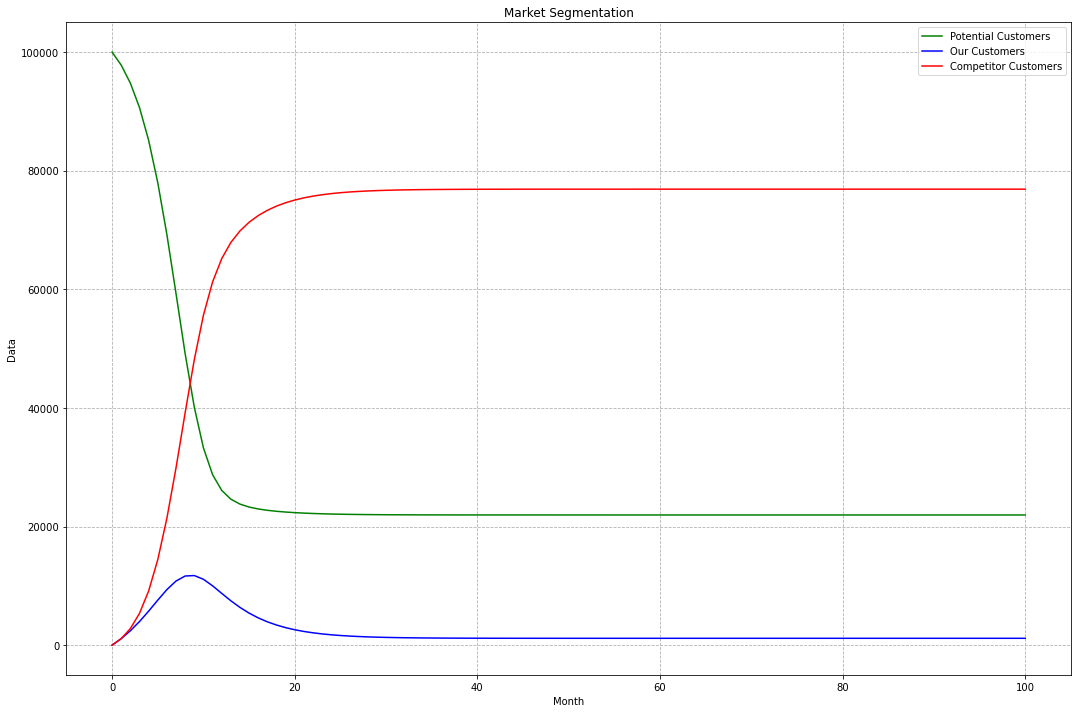

In [6]:
config = {
    "final_time": 40,
    "p11": 0.3,
    "p13": 0.5,
    "p21": 0.5,
    "p23": 0.4,
    "efficiency_word_of_mouth": 0.015,
    "efficiency_marketing": 0.011,
    "sociability": 100
}


values = run_model(model, params=config)
plot_chart(values)

### 2. Convergence Estimation

In [7]:
def get_equilibrium(values, eps=5e-2):
    """
    Method that computes market segmentation for a given model run.
    The observations are said to converge at time T iff |x_T - x_i| < eps
    for i ∈ [1..5]. Resultant values M1, M2 are values of columns 'Our Customers'
    and 'Competitor Customers' at time moment T. If the convergence test failed, 
    then it returns (None, None).

    :param values: dataframe (output of run)
    :param eps: epsilon value
    :return: M1, M2
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    new_labels = []
    new_values = values.copy()
    for label in labels:
        for offset in range(1, 6):
            new_label = f"{label} - {offset}"
            new_labels.append(new_label)
            new_values[new_label] = values[label].diff(periods=offset).abs()
    diffs = new_values[new_labels]
    converged = values[(diffs < eps).all(axis='columns')]
    if converged.empty:
        return None, None
    M1, M2 = converged[labels[1:]].iloc[0]
    return M1, M2


In [8]:
def simulate(p11, p13, p21, p23, final_time=200):
    """
    Method that runs simulation with given values 
    of P11, P13, P21, and P23. 

    :param p11: P11
    :param p13: P13
    :param p21: P21
    :param p23: P23
    :param final_time: simulation time
    :return: M1, M2
    """
    config = {
        "final_time": final_time,
        "p11": p11,
        "p13": p13,
        "p21": p21,
        "p23": p23,
        "efficiency_word_of_mouth": 0.015,
        "efficiency_marketing": 0.011,
        "sociability": 100
    }
    values = run_model(model, params=config)
    equilibrium = get_equilibrium(values)
    return np.array(equilibrium)

In [9]:
simulate(p11=0.3, p13=0.5, p21=0.5, p23=0.4)

array([ 1154.07744393, 76893.61592779])

### 3. Data Preparation

In [10]:
def simulate_wrapper(args):
    """
    Wrapper for simulate method. Used to run simulations
    in parallel.

    :return: M1, M2
    """
    return simulate(*args)

In [11]:
def generate_grid(step=0.1, preferences=None):
    """
    Method that generates a grid of P11, P13, P21, P23. Can forced to compute
    the grid within a certain interval for each P.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :return: dataframe 
    """
    if preferences is None:
        preferences = [[0, 1]] * 4
    preferences = np.array(preferences)
    assert preferences.shape == (4, 2), "Preferences is list of list of elements with two items: lower and upper bound for P"
    space = [np.arange(pref[0], pref[1] + step, step) for pref in preferences]
    grid = np.array(np.meshgrid(*space, indexing='ij')).T.reshape(-1, 4)
    labels =  ["P11", "P13", "P21", "P23", "S1", "S2"]
    df = pd.DataFrame(data=grid, columns=labels[:4])
    temp = pd.DataFrame(data=np.zeros((len(df), 2)), columns=labels[4:])
    for idx, label in enumerate(labels[4:]):
        temp[label] = df[labels[idx * 2]] + df[labels[idx * 2 + 1]]
    df = df[(temp <= 1.).all(axis='columns')].reset_index(drop=True)
    return df

In [12]:
def get_mapping(df):
    """
    Method that computes equilibrium of a system with a given
    set of P11, P13, P21, P23. Uses multiple processes to increase
    the speed.

    :param df: dataframe with predictors
    :return: ground truth
    """
    work = [[r["P11"], r["P13"], r["P21"], r["P23"]] for _, r in df.iterrows()]
    with Pool(max(os.cpu_count() - 1, 1)) as p:
        ground_truth = list(tqdm(p.imap(simulate_wrapper, work), total=len(work)))
    targets = pd.DataFrame(data=ground_truth, columns=["M1", "M2"])
    return targets

In [13]:
def export(df, flag):
    """
    Method that saves dataframe as a csv file.

    :param df: dataframe to be saved
    :param flag: flag whether it should be saved
    :return: True if save successfully
    """
    if not flag:
        return
    if not os.path.exists('./data'):
        os.makedirs('./data')
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filepath = os.path.join('./data', f'train | {timestamp}.csv')
    df.to_csv(filepath)
    return True

In [14]:
def compose_dataset(step=0.1, preferences=None, save=True):
    """
    Method that assembles dataset.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :param save: flag whether the result should be saved
    :return: dataframe 
    """
    df = generate_grid(step=step, preferences=preferences)
    targets = get_mapping(df)
    dataset = pd.concat([df, targets], axis=1).fillna(value=np.nan)
    export(dataset, save)        
    return dataset


In [15]:
dataset = compose_dataset()

100%|██████████| 4356/4356 [01:41<00:00, 42.76it/s]


In [16]:
dataset.head()

,P11,P13,P21,P23,M1,M2
0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.1,0.0,0.0,0.0,NaN,NaN
2,0.2,0.0,0.0,0.0,99999.969840,0.030160
3,0.3,0.0,0.0,0.0,99999.988991,0.011009
4,0.4,0.0,0.0,0.0,99999.994484,0.005516
